# Bioaerosol Tutorial

Bioaerosols build upon the Aerosols system, introducing biological material such as bacteria, viruses, and fungi. Here we go through an example of incorporating biological material into particula, and examine what it can do, and where we can improve in future code development.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import particula as par

Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['biological' 'water']"]
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 1.787e-04 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


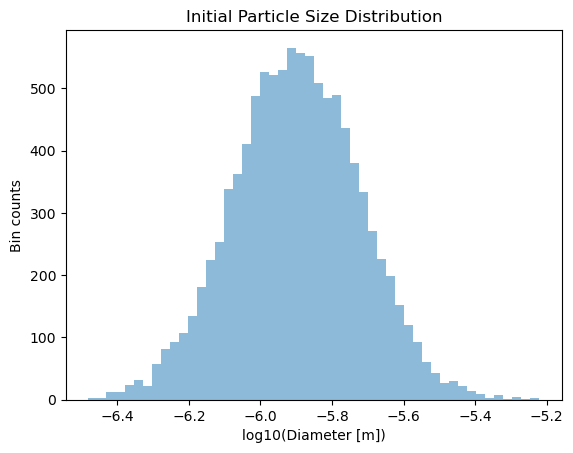

In [4]:
np.random.seed(100)

# 1a. Species properties
molar_mass_water = 18.01528e-3  # kg/mol
molar_mass_bio = 6.022e8  # kg/mol Assumed, based on ~1e-15 kg per bacterial cell

density_bio = 1000.0  # kg/m^3 Assumed. Average bacterial cell is 70% water
density_water = 1000.0 # kg/m^3

kappa_bio = 0.01  # hygroscopicity of biological particles
kappa_water = 0.01

number_of_samples = 10000  # number of particles to sample
simulation_volume = 1e-6  # 1/m^3
water_activity = 1.02  # initial water activity
temperature = 298.15

# Vapor pressure strategies
vapor_organics = (
    par.gas.ConstantBuilder().set_vapor_pressure(2e-12, "Pa").build()
)
vapor_bio = par.gas.ConstantBuilder().set_vapor_pressure(1e-30, "Pa").build()
vapor_water = par.gas.WaterBuckBuilder().build()

# Gas species
water_sat = vapor_water.saturation_concentration(molar_mass_water, temperature)
water_conc = water_sat * water_activity

gas_species = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(["biological", "water"]))
    .set_molar_mass(
        np.array([molar_mass_bio, molar_mass_water]),
        "kg/mol",
    )
    .set_condensable(True)
    .set_vapor_pressure_strategy([vapor_bio, vapor_water])
    .set_concentration(np.array([1e-14, water_conc]), "kg/m^3")
    .build()
)

atmosphere = (
    par.gas.AtmosphereBuilder()
    .add_species(gas_species)
    .set_temperature(temperature, "K")
    .set_pressure(1, "atm")
    .build()
)

radii_bio = par.particles.get_lognormal_sample_distribution(
    mode=np.array([1e-6]), # meters
    geometric_standard_deviation=np.array([1.5]),
    number_of_particles=np.array([1]),
    number_of_samples=number_of_samples,
)

mass_bio = 4 / 3 * np.pi * (radii_bio**3) * density_bio
mass_water = mass_bio

mass_speciation = np.column_stack((mass_bio, mass_water))

# Activity strategy
activity_strategy = (
    par.particles.ActivityKappaParameterBuilder()
    .set_density([density_bio, density_water], "kg/m^3")
    .set_molar_mass(
        [molar_mass_bio, molar_mass_water], "kg/mol"
    )
    .set_kappa(np.array([kappa_bio, kappa_water]))
    .set_water_index(2)
    .build()
)

surface_strategy = par.particles.SurfaceStrategyVolume()

# Create Particula particle object
resolved_masses = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy)
    .set_surface_strategy(surface_strategy)
    .set_mass(mass_speciation, "kg")
    .set_density(
        np.array([density_bio, density_water]), "kg/m^3"
    )
    .set_charge(0)  # no charge on particles
    .set_volume(simulation_volume, "m^3")
    .build()
)

# Create Aerosol object
aerosol = par.Aerosol(atmosphere=atmosphere, particles=resolved_masses)
print(aerosol)

# Plot initial size distribution
fig, ax = plt.subplots()
ax.hist(
    np.log10(resolved_masses.get_radius()), bins=50, density=False, alpha=0.5
)
ax.set_xlabel("log10(Diameter [m])")
ax.set_ylabel("Bin counts")
ax.set_title("Initial Particle Size Distribution");